# MNIST

Active learning on mnist dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mnist import read

# mnist image is 28 by 28 pixels
flat_shape = 28 * 28

%matplotlib inline

In [88]:
# Do some PCA
from sklearn.decomposition import PCA

reader = read()

batch_size = 60000

x = np.zeros((batch_size, flat_shape))
y = np.zeros(batch_size)
for i in range(batch_size):
    img = next(reader)

    x[i] = img[1].reshape(flat_shape)
    y[i] = img[0]


my_pca = PCA(10)

x_transformed = my_pca.fit_transform(x)

In [27]:
def least_confident(predictions, size=1):
    prob_max = np.argmax(predictions, axis=1)

    y_hat = predictions[np.arange(len(predictions)), prob_max]

    # least_confident = np.argmax(1 - y_hat)
    least_confident = np.argsort(1 - y_hat)[-size:]
    
    return least_confident


def random_selection(predictions, size=1):
    return np.random.choice(predictions.shape[0], size=size)

In [28]:
def next_sample(X_train, y_train, unlabeled, y_unlabeled, index):
    # add index to the traning set
    X_train = np.concatenate((X_train, unlabeled[index, :]))
    y_train = np.concatenate((y_train, y_unlabeled[index]))
    
    # remove it from the unlabeled set
    unlabeled = np.delete(unlabeled, (index), axis=0)
    y_unlabeled = np.delete(y_unlabeled, (index), axis=0)
    
    return X_train, y_train, unlabeled, y_unlabeled

In [83]:
# Create training and test sets
from sklearn.model_selection import train_test_split

def init_sets(X, y, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=random_state, stratify=y)


    X_train, unlabeled, y_train, y_unlabeled = train_test_split(X_train, y_train, test_size=X_train.shape[0]-10,
                                                                train_size=10, random_state=random_state,
                                                                stratify=y_train)
    
    return X_train, X_test, unlabeled, y_train, y_test, y_unlabeled

In [84]:
# Train the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def train_model(model, model_args, no_models, al_sample_size, X, y, selection_method=least_confident, random_state=42):
    X_train, X_test, unlabeled, y_train, y_test, y_unlabeled = init_sets(X, y)

    accuracy = np.zeros(no_models + 1)
    train_accuracy = np.zeros(no_models + 1)
    for i in range(no_models):
        # Test the current model against
        # 1. the test set
        test_pred = model.predict(X_test)
        accuracy[i] = accuracy_score(y_test, test_pred)

        # 2. the training set
        train_pred = model.predict(X_train)
        train_accuracy[i] = accuracy_score(y_train, train_pred)


        # Select a new datapoint for the training set
        # #activelearning
        predictions = model.predict_proba(unlabeled)
        lc = selection_method(predictions, al_sample_size)

        X_train, y_train, unlabeled, y_unlabeled = next_sample(X_train, y_train, unlabeled, y_unlabeled, lc)
        
        print("Model: #", i, "train_accuracy:", train_accuracy[i], "test_accuracy:", accuracy[i])

        # Train a new model using the new training set
        model = RandomForestClassifier(**model_args)
        model.fit(X_train, y_train)
    
    predictions = model.predict(X_train)
    train_accuracy[no_models] = accuracy_score(y_train, predictions)

    test_pred = model.predict(X_test)
    accuracy[no_models] = accuracy_score(y_test, test_pred)
        
    return model, accuracy, train_accuracy

In [85]:
model_args = {
    'n_estimators': 100,
    'max_depth': 6
}
model = RandomForestClassifier(**model_args)
# Pre-Training
model.fit(X_train, y_train)

al_sample_size = 100
sample_total = X_train.shape[0] + unlabeled.shape[0]
no_models = int(sample_total / al_sample_size)

print("Training using least confidence")
lc_model, lc_accuracy, lc_train_accuracy = train_model(model, model_args, no_models, al_sample_size,
                                                       x_transformed, y, selection_method=least_confident)


print("Training using random")
model = RandomForestClassifier(**model_args)
# Pre-Training
model.fit(X_train, y_train)
rand_model, rand_accuracy, rand_train_accuracy = train_model(model, model_args, no_models, al_sample_size,
                                                             x_transformed, y, selection_method=random_selection)

(0, 45000)

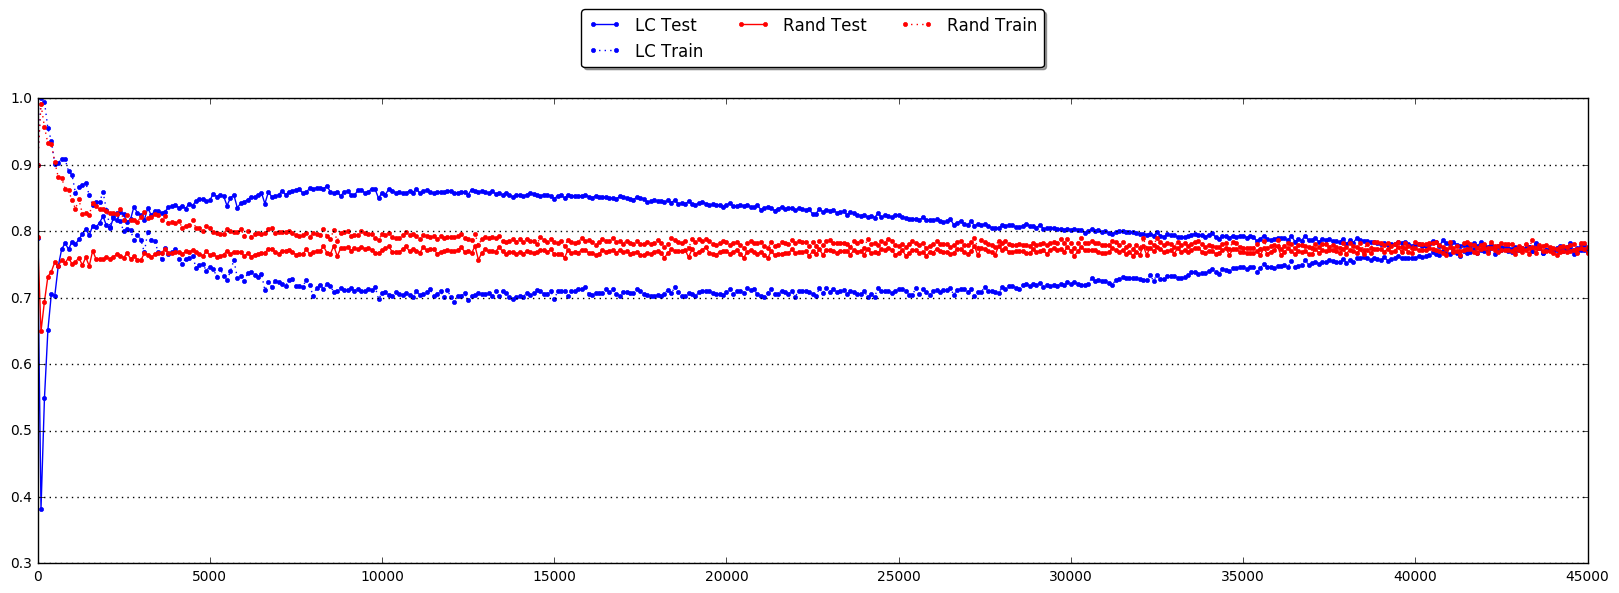

In [86]:
x = np.linspace(0, sample_total, no_models+1)

fig = plt.figure(figsize=(20, 6), dpi=80)

plt.plot(x, lc_accuracy, label='LC Test', marker='.', color='b')
plt.plot(x, lc_train_accuracy, label='LC Train', marker='.', color='b', ls=':')

plt.plot(x, rand_accuracy, label='Rand Test', marker='.', color='r')
plt.plot(x, rand_train_accuracy, label='Rand Train', marker='.', color='r', ls=':')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color='k', linestyle=':', axis='y', linewidth=1)
plt.ylim(0.3, 1)
plt.xlim(0, sample_total)

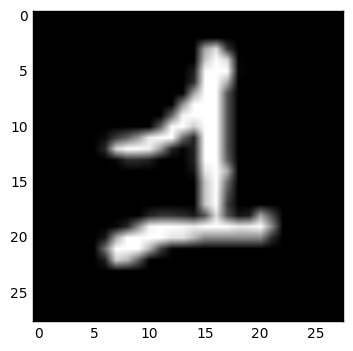

In [119]:
img = next(reader)

# X = my_pca.transform(img[1].reshape(flat_shape).reshape(1, -1))

# answer = model.predict_proba(X)

# print("Predicted: ", np.argmax(answer[0]))
# print("Confidence: ", answer[0])
# print("Actual: ", img[0])

plt.imshow(img[1], cmap=plt.cm.gray)